In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
import math
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchinfo import summary
from tqdm import tqdm

print(torch.__version__)

#乱数固定用の処理
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(123)
torch.cuda.manual_seed(123)

c:\Users\ohno\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.1+cu113
cuda


In [2]:
df = pd.read_csv("C:/Users/ohno/study/data/price.csv")
df = df.drop(columns=['Unnamed: 0'])

df[60:]

,Date,Open,High,Low,Close,MACD,Signal,RSI,SMA5,SMA25,Label
60,2001/5/31,13394.75,13419.94,13216.57,13262.14,-27.046261,89.260492,32.603607,13606.614,13958.5796,0
61,2001/6/1,13365.08,13394.40,13244.90,13261.84,-63.880084,64.973333,35.282417,13505.798,13939.3260,0
62,2001/6/4,13294.21,13312.35,13213.65,13312.35,-87.982607,38.305083,30.942103,13420.714,13918.7200,1
63,2001/6/5,13232.52,13256.40,12984.07,13182.00,-116.258079,9.128361,35.077631,13302.336,13887.0788,0
64,2001/6/6,13289.59,13313.14,13127.62,13174.84,-137.657155,-20.221882,25.589666,13238.634,13856.6996,0
...,...,...,...,...,...,...,...,...,...,...,...
4956,2021/4/14,29718.06,29722.40,29567.18,29620.99,109.455309,106.458295,65.115498,29677.674,29526.6704,0
4957,2021/4/15,29573.90,29787.66,29558.55,29642.69,103.346146,113.052751,59.236487,29664.416,29543.9124,1
4958,2021/4/16,29789.08,29789.08,29621.83,29683.37,100.627160,113.333455,56.343906,29647.478,29542.5340,1
4959,2021/4/19,29688.32,29808.01,29530.84,29685.37,97.509696,112.162026,55.470871,29676.806,29539.2700,1


In [3]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, labels_list, image_transform=None, transform=None):
        self.file_list = file_list
        self.labels_list = labels_list
        self.image_transform = image_transform
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_dir = self.file_list[idx]
        image_path_list = glob.glob(os.path.join(img_dir,'*.png'))
        labels = self.labels_list[idx]

        images_list = []
        for img_path in image_path_list:
            img = Image.open(img_path).convert('RGB')
            images_list.append(self.image_transform(img))
            images = torch.stack(images_list, dim=0)

        labels =  labels.reshape(1, -1)
        labels = self.transform(labels)

        return images, labels.squeeze()

In [4]:
class MyTransforms:
    def __init__(self) -> None:
        pass

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # x = x.to(torch.float32)
        x = x.to(torch.int64)
        return x

In [5]:
transform = transforms.Compose([
        transforms.ToTensor(),
        MyTransforms()
        ])

image_transform = transforms.Compose([
        # transforms.Grayscale(num_output_channels=1),
        # transforms.CenterCrop(100),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
        ])

date_span = 60
labels_list = []
train_dir = 'C:/Users/ohno/study/images/stride/60day/3stride/'
train_orig_list = glob.glob(f'{train_dir}/*/**/', recursive=True)
img_path_list = glob.glob(os.path.join(train_orig_list[0],'*.png'))
print(len(train_orig_list))

for i in range(len(train_orig_list)):
    labels_list.append(df.loc[i+date_span+30, 'Label'])
labels_list = np.array(labels_list).reshape(-1,1)
print(labels_list.shape)

images_list = []
for img_path in img_path_list:
    img = Image.open(img_path).convert('RGB')
    images_list.append(image_transform(img))
    images = torch.stack(images_list, dim=0)
print(images.shape)
# img = images[0].permute(1,2,0)
# plt.imshow(img)

4385
(4385, 1)
torch.Size([11, 3, 224, 224])


train_list size: 4140
train_labels size: (4140, 1)

test_list size: 245
test_labels size: (245, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images size: torch.Size([32, 11, 3, 224, 224])
labels size: torch.Size([32])
torch.int64


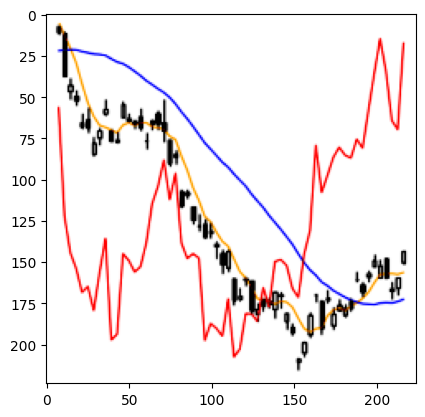

In [6]:
train_len = 4140    #2018-04-17まで
val_len = 4385     #2019-04-17まで

train_list, test_list = train_test_split(train_orig_list, train_size = train_len, shuffle=False)
train_labels, test_labels = train_test_split(labels_list, train_size = train_len, shuffle=False)

print(f"train_list size: {len(train_list)}")
print(f"train_labels size: {train_labels.shape}\n")
print(f"test_list size: {len(test_list)}")
print(f"test_labels size: {test_labels.shape}")

train_dataset = ImageDataset(train_list, train_labels, image_transform=image_transform, transform=transform)
val_dataset = ImageDataset(test_list, test_labels, image_transform=image_transform, transform=transform)

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

for images, labels in train_loader:
    img = images[0,0].permute(1,2,0)
    plt.imshow(img, cmap='gray')
    break
# labels = labels.unsqueeze(-1)
print(f"images size: {images.shape}")
print(f"labels size: {labels.shape}")
print(labels.dtype)

In [7]:
# def t2v(tau, f, out_features, w, b, w0, b0, arg=None):
#     if arg:
#         v1 = f(torch.matmul(tau, w) + b, arg)
#     else:
#         print(tau.shape, w.shape, b.shape)
#         v1 = f(torch.matmul(tau, w) + b)
#     v2 = torch.matmul(tau, w0) + b0
#     # print(v1.shape)
#     # print(v2.shape)
#     return torch.cat([v1, v2], -1)

# class SineActivation(nn.Module):
#     def __init__(self, in_features, out_features):
#         super(SineActivation, self).__init__()
#         self.out_features = out_features
#         self.w0 = nn.parameter.Parameter(torch.randn(in_features, 1))
#         self.b0 = nn.parameter.Parameter(torch.randn(in_features, 1))
#         self.w = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
#         self.b = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
#         self.f = torch.sin

#     def forward(self, tau):
#         return t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0)

In [8]:
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, dropout = 0.1, max_len = 5000):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)
#         self.d_model = d_model

#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         x = x + self.pe[:, :x.size(1)]
#         return self.dropout(x)

In [9]:
# class CNNTransformer(nn.Module):
#   def __init__(self, sequence_size, cnn_hidden_size, d_model, nhead, num_layers, d_output):
#     super().__init__()
#     self.sequence_size=sequence_size
#     self.conv1 = nn.Conv2d(3, 5, 5)
#     self.conv2 = nn.Conv2d(5, 10, 5)
#     self.relu = nn.ReLU(inplace=True)
#     self.maxpool = nn.MaxPool2d((2,2))
#     self.flatten = nn.Flatten()
    
#     self.embedding = SineActivation(cnn_hidden_size, d_model)
#     encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dropout=0.2, batch_first=True)
#     self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
#     self.fc1 = nn.Linear(10 * 53 * 53, cnn_hidden_size)
#     self.fc2 = nn.Linear(d_model, d_output)
#     self.dropout = nn.Dropout(0.2)

#     self.cnn = nn.Sequential(
#         self.conv1,
#         self.relu,
#         self.maxpool,
#         self.conv2,
#         self.relu,
#         self.maxpool,
#         self.dropout,
#         self.flatten,
#         self.fc1,
#         self.relu,
#         self.dropout,
#     )

#     self.init_weights()

#   def init_weights(self):
#     initrange = 0.1    
#     self.fc2.bias.data.zero_()
#     self.fc2.weight.data.uniform_(-initrange, initrange)

#   def forward(self, images):
#     """
#     images shape: (batch_size, sequence_size, channel_size, img_size, img_size)
#     hidden list shape: (batch_size, sequence_size, cnn_hidden_size)
#     pos_src shape: (batch_size, sequence_size, d_model)

#     """
#     hidden_list = []
#     for i in range(self.sequence_size):
#         hidden = self.cnn(images[:,i])
#         hidden_list.append(hidden)
#     hidden_list = torch.stack(hidden_list, dim=0)
#     self.hidden_list = torch.permute(hidden_list, (1,0,2))

#     pos_src = self.embedding(self.hidden_list)
#     memory = self.transformer_encoder(pos_src)
#     output = self.fc2(memory)
#     return output

In [10]:
class CRNN(nn.Module):
    def __init__(self, sequence_size, cnn_hidden_size, n_layers, rnn_hidden_size, output_size):
        super().__init__()
        self.sequence_size=sequence_size
        self.n_layers = n_layers
        self.rnn_hidden_size = rnn_hidden_size

        self.conv1 = nn.Conv2d(3, 5, 5)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2,2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(10 * 53 * 53, cnn_hidden_size)
        self.rnn = nn.RNN(cnn_hidden_size, rnn_hidden_size, n_layers, batch_first=True)
        self.fc2 = nn.Linear(rnn_hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

        self.cnn = nn.Sequential(
            self.conv1,
            self.relu,
            self.maxpool,
            self.conv2,
            self.relu,
            self.maxpool,
            self.dropout,
            self.flatten,
            self.fc1,
            self.relu,
            self.dropout,
        )

    def forward(self, x):
        """
        x shape: (batch_size, sequence_size, channel_size, img_size, img_size)
        hidden list(RNN input) shape: (batch_size, sequence_size, cnn_hidden_size)
        h0 shape: (n_layers, batch_size, rnn_hidden_size)

        """
        hidden_list = []
        for i in range(self.sequence_size):
            hidden = self.cnn(x[:,i])
            hidden_list.append(hidden)
        hidden_list = torch.stack(hidden_list, dim=0)
        self.hidden_list = torch.permute(hidden_list, (1,0,2))

        h0 = torch.zeros(self.n_layers, self.hidden_list.size(0), self.rnn_hidden_size).to(device)
        out, h = self.rnn(self.hidden_list, h0)
        output = self.fc2(out[:, -1, :])
        return output

In [11]:
# class CLSTM(nn.Module):
#     def __init__(self, sequence_size, cnn_hidden_size, n_layers, rnn_hidden_size, output_size):
#         super().__init__()
#         self.sequence_size=sequence_size
#         self.n_layers = n_layers
#         self.rnn_hidden_size = rnn_hidden_size

#         self.conv1 = nn.Conv2d(3, 5, 5)
#         self.conv2 = nn.Conv2d(5, 10, 5)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d((2,2))
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(10 * 53 * 53, cnn_hidden_size)
#         self.rnn = nn.LSTM(cnn_hidden_size, rnn_hidden_size, n_layers, batch_first=True)
#         self.fc2 = nn.Linear(rnn_hidden_size, output_size)
#         self.dropout = nn.Dropout(0.2)

#         self.cnn = nn.Sequential(
#             self.conv1,
#             self.relu,
#             self.maxpool,
#             self.conv2,
#             self.relu,
#             self.maxpool,
#             self.dropout,
#             self.flatten,
#             self.fc1,
#             self.relu,
#             self.dropout,
#         )

#     def forward(self, x):
#         """
#         x shape: (batch_size, sequence_size, channel_size, img_size, img_size)
#         hidden list(LSTM input) shape: (batch_size, sequence_size, cnn_hidden_size)
#         h0 shape: (n_layers, batch_size, rnn_hidden_size)

#         """
#         hidden_list = []
#         for i in range(self.sequence_size):
#             hidden = self.cnn(x[:,i])
#             hidden_list.append(hidden)
#         hidden_list = torch.stack(hidden_list, dim=0)
#         self.hidden_list = torch.permute(hidden_list, (1,0,2))

#         h0 = torch.zeros(self.n_layers, self.hidden_list.size(0), self.rnn_hidden_size).to(device)
#         c0 = torch.zeros(self.n_layers, self.hidden_list.size(0), self.rnn_hidden_size).to(device)
#         out, _ = self.rnn(self.hidden_list, (h0, c0))
#         output = self.fc2(out[:, -1, :])
#         return output

In [12]:
# class CNN(nn.Module):
#   def __init__(self, n_output, n_hidden):
#     super().__init__()
#     self.conv1 = nn.Conv2d(3, 5, 5)
#     self.conv2 = nn.Conv2d(5, 10, 5)
#     self.relu = nn.ReLU(inplace=True)
#     self.maxpool = nn.MaxPool2d((2,2))
#     self.flatten = nn.Flatten()
#     self.l1 = nn.Linear(10 * 53 * 53, n_hidden)
#     self.l2 = nn.Linear(n_hidden, n_output)
#     self.softmax = nn.Softmax(dim=1)
#     self.sigmoid = nn.Sigmoid()
#     self.dropout = nn.Dropout(0.2)

#   def forward(self, x):
#     x1 = self.conv1(x)
#     x2 = self.relu(x1)
#     x3 = self.maxpool(x2)
#     x4 = self.conv2(x3)
#     x5 = self.relu(x4)
#     x6 = self.maxpool(x5)
#     x7 = self.dropout(x6)
#     x8 = self.flatten(x7)
#     x9 = self.l1(x8)
#     x10 = self.relu(x9)
#     x11 = self.dropout(x10)
#     x11 = self.l2(x11)
#     return x11

# from torchinfo import summary
# net = CNN(n_output = 2, n_hidden = 128)
# summary(net)

In [14]:
sequence_size = 11
batch_size = 32
img_size = 224
hidden_size = 128
a = torch.zeros((32, 11, 3, 224, 224))
print(a[0].shape)

conv1 = nn.Conv2d(3, 5, 5)
conv2 = nn.Conv2d(5, 10, 5)
relu = nn.ReLU(inplace=True)
maxpool = nn.MaxPool2d((2,2))
flatten = nn.Flatten()

fc1 = nn.Linear(10 * 53 * 53, hidden_size)

cnn = nn.Sequential(
        conv1,
        relu,
        maxpool,
        conv2,
        relu,
        maxpool,
        flatten,
        fc1
)

hidden_list = []
for i in range(sequence_size):
        hidden = cnn(a[:,i])
        hidden_list.append(hidden)
tensor_list = torch.stack(hidden_list, dim=0)
tensor_list = torch.permute(tensor_list, (1,0,2))

print(hidden_list[0])
print(tensor_list.shape)

torch.Size([11, 3, 224, 224])
tensor([[ 0.0363,  0.0370,  0.0223,  ...,  0.0172,  0.0421, -0.0003],
        [ 0.0363,  0.0370,  0.0223,  ...,  0.0172,  0.0421, -0.0003],
        [ 0.0363,  0.0370,  0.0223,  ...,  0.0172,  0.0421, -0.0003],
        ...,
        [ 0.0363,  0.0370,  0.0223,  ...,  0.0172,  0.0421, -0.0003],
        [ 0.0363,  0.0370,  0.0223,  ...,  0.0172,  0.0421, -0.0003],
        [ 0.0363,  0.0370,  0.0223,  ...,  0.0172,  0.0421, -0.0003]],
       grad_fn=<AddmmBackward0>)
torch.Size([32, 11, 128])


In [15]:
def train():
    epochs = 100
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in tqdm(range(epochs+1)):
        net.train()
        train_loss = 0
        train_acc = 0
        total = 0
        for j, (inputs, labels) in enumerate(train_loader):
            total += labels.size(0)
            # labels = labels.unsqueeze(-1)
            # labels = labels.to(torch.float64)
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            predicted = torch.max(outputs, 1)[1]
            # predicted = torch.where(outputs < 0.5, 0, 1)
            train_loss += loss.item()
            train_acc += (predicted == labels).sum().item()
        train_loss /= j+1
        train_acc /= total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        scheduler.step()
        
        net.eval()
        with torch.no_grad():
            val_loss = 0
            val_acc = 0
            total = 0
            for j, (inputs, labels) in enumerate(val_loader):
                total += labels.size(0)
                # labels = labels.unsqueeze(-1)
                # labels = labels.to(torch.float64)

                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                predicted = torch.max(outputs, 1)[1]
                # predicted = torch.where(outputs < 0.5, 0, 1)
                val_loss += loss.item()
                val_acc += (predicted == labels).sum().item()
            val_loss /= j+1
            val_acc /= total
            val_loss_history.append(val_loss)
            val_acc_history.append(val_acc)
        print(f"Epoch: {epoch+1}, train_loss: {train_loss}, train_acc: {train_acc}, val_loss: {val_loss}, val_acc: {val_acc}")
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history 

In [16]:
def test():
    net.eval()
    with torch.no_grad():
        test_acc = 0
        total = 0
        for inputs, labels in val_loader:
            total += labels.size(0)
            # labels = labels.unsqueeze(-1)
            
            inputs = inputs.to(device)
            outputs = net(inputs)
            outputs = outputs.to('cpu')
            predicted = torch.max(outputs, 1)[1]
            # predicted = torch.where(outputs < 0.5, 0, 1)
            test_acc += (predicted == labels).sum().item()
        test_acc /= total

    return test_acc

In [17]:
total_train_loss_history = []
total_train_acc_history = []
total_val_loss_history = []
total_val_acc_history = []
total_test_acc = []

for i in range(1):
    net = CRNN(sequence_size = 11, cnn_hidden_size = 128, n_layers = 1, rnn_hidden_size = 96, output_size = 2).to(device)
    # net = CLSTM(sequence_size = 4, cnn_hidden_size = 128, n_layers = 1, rnn_hidden_size = 64, output_size = 2).to(device)
    # net = CNNTransformer(sequence_size = 3, cnn_hidden_size = 128, d_model = 200, nhead = 4, num_layers = 1, d_output = 2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    tlh, tah, vlh, vah = train()
    tmp_test_acc = test()
    total_train_loss_history.append(tlh)
    total_train_acc_history.append(tah)
    total_val_loss_history.append(vlh)
    total_val_acc_history.append(vah)
    total_test_acc.append(tmp_test_acc)

train_loss_history = np.mean(np.array(total_train_loss_history), axis=0)
train_acc_history = np.mean(np.array(total_train_acc_history), axis=0)
val_loss_history = np.mean(np.array(total_val_loss_history), axis=0)
val_acc_history = np.mean(np.array(total_val_acc_history), axis=0)
test_acc = np.mean(np.array(total_test_acc), axis=0)

plt.plot(range(len(train_loss_history)), train_loss_history, label='train_loss', color='blue')
plt.plot(range(len(val_loss_history)), val_loss_history, label='val_loss', color='orange')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.plot(range(len(train_acc_history)), train_acc_history, label='train_acc', color='blue')
plt.plot(range(len(val_acc_history)), val_acc_history, label='val_acc', color='orange')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

  1%|          | 1/101 [04:40<7:47:25, 280.45s/it]

Epoch: 1, train_loss: 0.6938065813137935, train_acc: 0.5091787439613527, val_loss: 0.6889917477965355, val_acc: 0.5387755102040817


  2%|▏         | 2/101 [08:46<7:09:44, 260.45s/it]

Epoch: 2, train_loss: 0.692630396439479, train_acc: 0.5176328502415459, val_loss: 0.6894038692116737, val_acc: 0.5387755102040817


  3%|▎         | 3/101 [12:53<6:55:03, 254.12s/it]

Epoch: 3, train_loss: 0.6920903957807101, train_acc: 0.5164251207729469, val_loss: 0.6894561424851418, val_acc: 0.5387755102040817


  4%|▍         | 4/101 [17:00<6:46:21, 251.36s/it]

Epoch: 4, train_loss: 0.6919995702230013, train_acc: 0.5205314009661836, val_loss: 0.6903095543384552, val_acc: 0.5387755102040817


  5%|▍         | 5/101 [21:08<6:40:10, 250.11s/it]

Epoch: 5, train_loss: 0.6913624149102431, train_acc: 0.5243961352657005, val_loss: 0.6891065463423729, val_acc: 0.5387755102040817


  6%|▌         | 6/101 [25:15<6:34:24, 249.10s/it]

Epoch: 6, train_loss: 0.6907608674122737, train_acc: 0.5214975845410628, val_loss: 0.6897038146853447, val_acc: 0.5387755102040817


  6%|▌         | 6/101 [27:43<7:19:00, 277.27s/it]


KeyboardInterrupt: 